In [5]:
# Basic regression: Predict fuel efficiency 

In [6]:
import matplotlib.pyplot as plt
import numpy as np  
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

In [7]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.13.0


In [8]:
# Get the data
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)

In [9]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [10]:
# Clean the data
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [11]:
dataset = dataset.dropna()

In [12]:
dataset['Origin'] = dataset['Origin'].map({1:'USA', 2:'Europe', 3:'Japan'})

In [13]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


In [14]:
# Split the data into training and test set
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

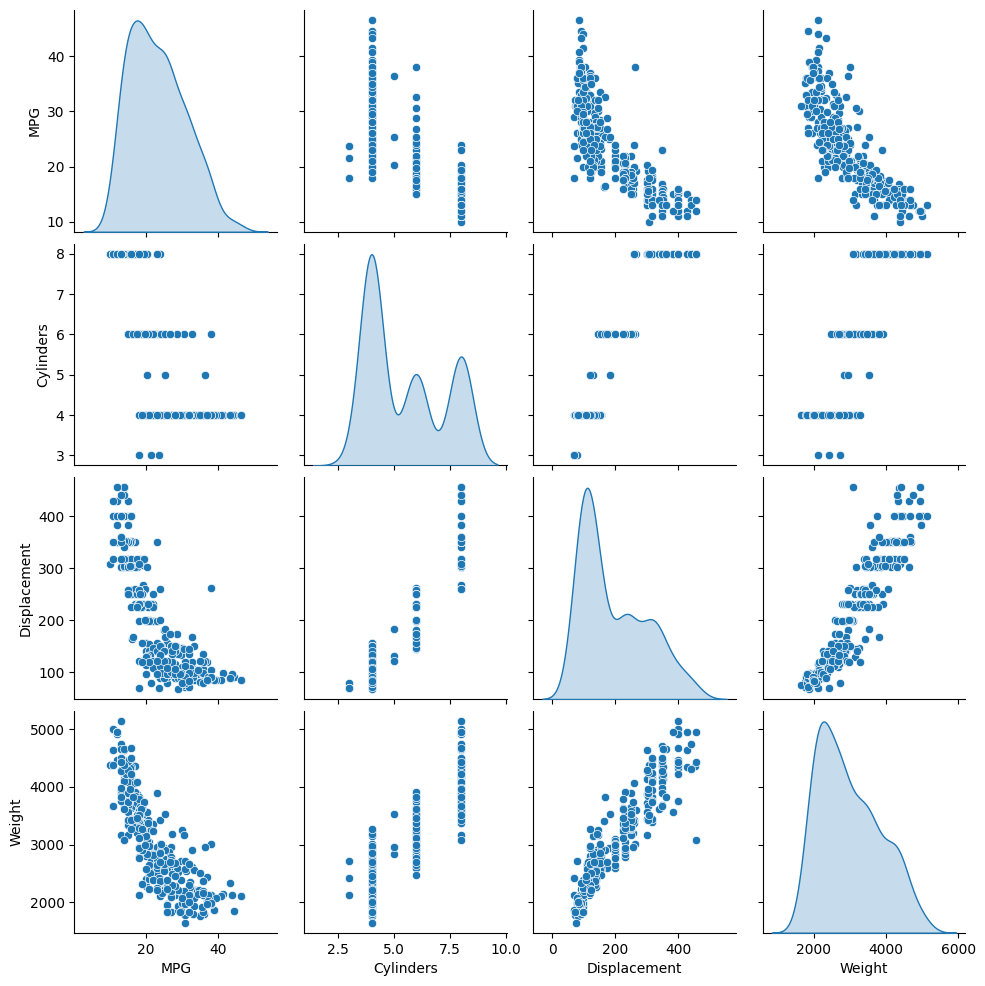

In [15]:
# Inspect the data
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [16]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [17]:
# Split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [18]:
# Normalization
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


In [19]:
# The normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)

In [20]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 314 entries, 146 to 182
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cylinders     314 non-null    int64  
 1   Displacement  314 non-null    float64
 2   Horsepower    314 non-null    float64
 3   Weight        314 non-null    float64
 4   Acceleration  314 non-null    float64
 5   Model Year    314 non-null    int64  
 6   Europe        314 non-null    bool   
 7   Japan         314 non-null    bool   
 8   USA           314 non-null    bool   
dtypes: bool(3), float64(4), int64(2)
memory usage: 18.1 KB


In [21]:
train_features[['Europe', 'Japan', 'USA']] = train_features[['Europe', 'Japan', 'USA']].astype(int)

In [22]:
normalizer.adapt(train_features)

In [23]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [24]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example: ', first)
    print()
    print('Normalized: ', normalizer(first).numpy())

First example:  [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized:  [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [25]:
# Linear Regression

In [26]:
train_features.columns

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'Europe', 'Japan', 'USA'],
      dtype='object')

In [27]:
horsepower = train_features['Horsepower']

In [28]:

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)


In [29]:
horsepower_normalizer.adapt(train_features['Horsepower'])

In [30]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [31]:
# This model will predict 'MPG' from 'horsepower'
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 104ms/step


array([[-1.096],
       [-0.619],
       [ 2.024],
       [-1.537],
       [-1.39 ],
       [-0.546],
       [-1.647],
       [-1.39 ],
       [-0.362],
       [-0.619]], dtype=float32)

In [32]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [33]:
# Use keras.Model.fit to execute the training for 100 epochs
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    #Suppress logging,
    verbose=0,
    # Calculating validation results on 20 % of the training data
    validation_split = 0.2
)

In [34]:
# Visualize the model's training progress using stats stored in the history object
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
0,22.865778,22.938503,0


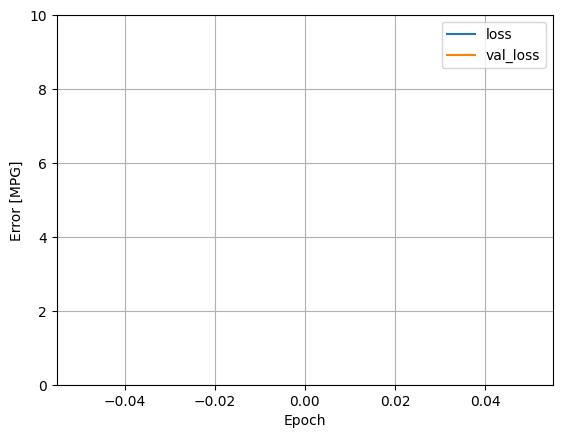

In [40]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

plot_loss(history)

In [41]:
# Collect the results on the test set for later:

In [42]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0
)

In [43]:
# Since this is a single variable regression it's easy to view the model's predictions as a function of the input

In [44]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 1ms/step


In [45]:
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

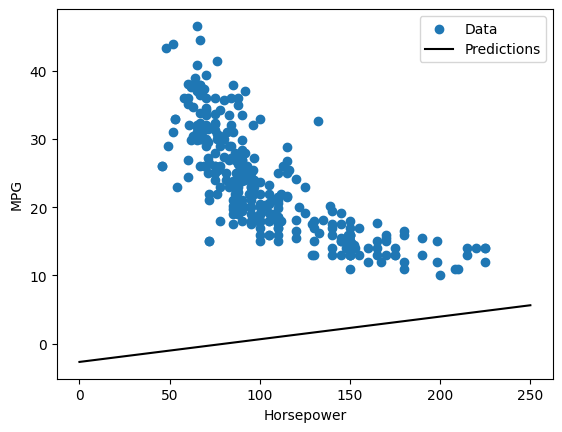

In [46]:
plot_horsepower(x, y)

In [47]:
# Linear regression with multiple inputs

In [48]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [49]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 61ms/step


array([[ 0.286],
       [-0.825],
       [-0.705],
       [-0.499],
       [ 1.153],
       [-1.008],
       [ 1.131],
       [-0.555],
       [-0.424],
       [ 1.606]], dtype=float32)

In [50]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.106],
       [-0.418],
       [-0.102],
       [-0.098],
       [-0.327],
       [-0.336],
       [ 0.367],
       [ 0.756],
       [ 0.03 ]], dtype=float32)>

In [51]:
# Configure the model with keras Model.compile and train with model.fit for 100 epochs

In [54]:
linear_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [55]:
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on  20% of the training data
    validation_split=0.2
)

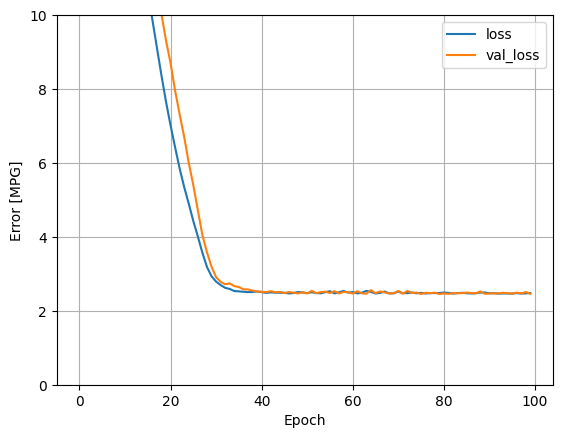

In [56]:
plot_loss(history)

In [57]:
# Collect the result on the test set later

In [63]:
test_features[['Europe', 'Japan', 'USA']] = test_features[['Europe', 'Japan', 'USA']].astype(int)

In [64]:
test_results['linear_model'] = linear_model.evaluate( test_features, test_labels, verbose=0)

In [65]:
# REGRESSION WITH A DEEP NEURAL NETWORK (DNN)

In [69]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [70]:
# Regression using a DNN and a single input

In [71]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [72]:
dnn_horsepower_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_5 (Dense)             (None, 64)                128       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4356 (17.02 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [73]:
# Train model with keras model.fit

In [74]:
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100
)

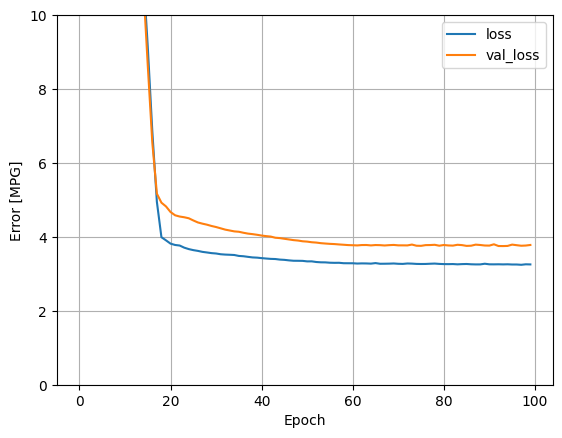

In [75]:
plot_loss(history)

In [76]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 794us/step


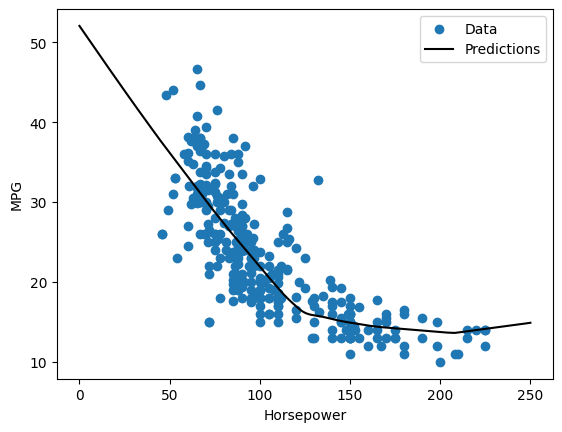

In [77]:
plot_horsepower(x, y)

In [78]:
# Collect the results on the test set for later

In [79]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels,
    verbose=0
)

In [80]:
# Regression using a DNN and multiple inputs

In [81]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 9)                 19        
 on)                                                             
                                                                 
 dense_8 (Dense)             (None, 64)                640       
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4884 (19.08 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


In [82]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100
)

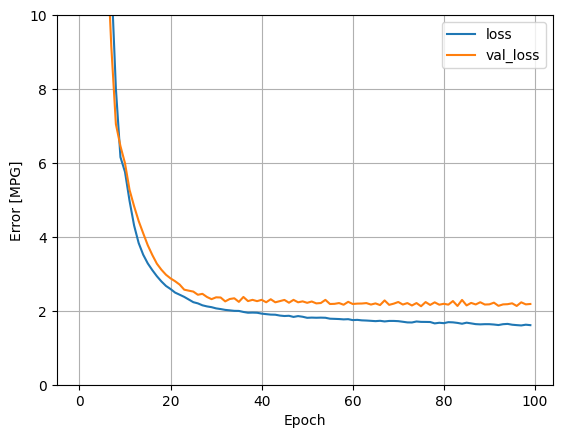

In [83]:
plot_loss(history)

In [84]:
# Collect the  results on the test set
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [85]:
# PERFORMANCE

In [86]:
# Since all models have been trained, you can review their set performance

In [87]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,23.257883
linear_model,2.506975
dnn_horsepower_model,2.933618
dnn_model,1.689725


In [88]:
# These results match the validation error observed during training

In [90]:
# Make predictions
# We can make predictions  with the dnn_model on the test set using keras.predict and review the loss

In [124]:
test_predictions = dnn_model.predict(test_features).flatten()

3/3 [==============================] - 0s 2ms/step


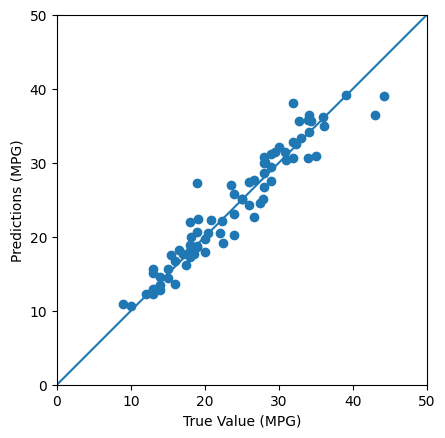

In [92]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Value (MPG)')
plt.ylabel('Predictions (MPG)')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [94]:
# It appears that the model predicts reasonable well.
# Now check the error distribution

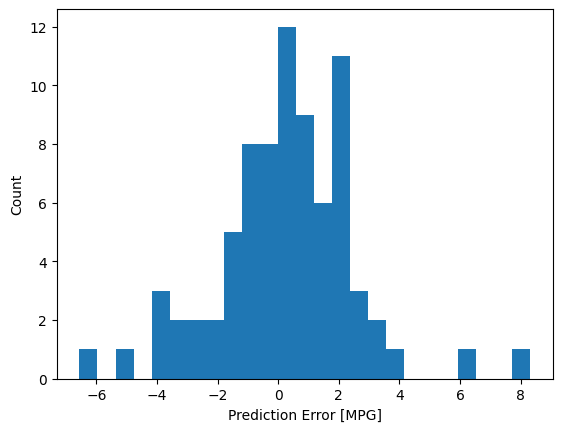

In [95]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [102]:
# If you are happy with the performance of the model, save it for later use
dnn_model.save('dnn_model.keras')

In [123]:
# If you reload the model it gives identical results
reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0
)

ValueError: All `axis` values to be kept must have known shape. Got axis: (-1,), input shape: [None, None], with unknown axis at index: 1

In [ ]:
# Somehow model reloading is not working    

In [121]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,23.257883
linear_model,2.506975
dnn_horsepower_model,2.933618
dnn_model,1.689725


In [125]:
test_results['reloaded'] = dnn_model.evaluate(
    test_features, test_labels, verbose=0
)

In [126]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,23.257883
linear_model,2.506975
dnn_horsepower_model,2.933618
dnn_model,1.689725
reloaded,1.689725
